# 자동차 연비 예측하기: 회귀

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것입니다.

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import pandas as pd

## Auto MPG 데이터셋

이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.

### 데이터 구하기
먼저 데이터셋을 다운로드합니다.

In [2]:
import os
import urllib.request

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
file_name = "auto-mpg.data"

# Download the file from the provided URL
urllib.request.urlretrieve(url, file_name)

# Get the current working directory
current_directory = os.getcwd()

# Combine the directory with the file name to get the full path
dataset_path = os.path.join(current_directory, file_name)

print("The file is saved at:", dataset_path)

The file is saved at: /content/auto-mpg.data


판다스를 사용하여 데이터를 읽습니다.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                             'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values = "?", comment='\t',
                        sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [5]:
dataset = dataset.dropna()

`"Origin"` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:  
1 - `USA`  
2 - `Europe`  
3 - `Japan`

In [6]:
# dataset에서 Origin column 제거 & value 저장
origin = dataset.pop('Origin')

In [7]:
# origin column 값을 one-hot-encoding 변환
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

<ipython-input-7-473096df6c77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['USA'] = (origin == 1) * 1.0
<ipython-input-7-473096df6c77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Europe'] = (origin == 2) * 1.0
<ipython-input-7-473096df6c77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


전반적인 통계 확인

In [8]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.625000,0.173469,0.201531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.484742,0.379136,0.401656
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


### 데이터셋을 훈련 세트와 테스트 세트로 분할하기

In [9]:
from sklearn.model_selection import train_test_split

# 특성과 label 분리
X = dataset.drop('MPG', axis=1).values
y = dataset['MPG'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 9), (79, 9), (313,), (79,))

### 데이터 정규화
MinMAX scaling : (X - min) / (max - min)

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

## 모델

In [11]:
model = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=[9]),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 훈련


In [13]:
EPOCHS = 500

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                     validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/500
10/10 [==============================] - 7s 24ms/step - loss: 608.7146 - mae: 23.4081 - mse: 608.7146 - val_loss: 593.9631 - val_mae: 23.0404 - val_mse: 593.9631
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 593.4207 - mae: 23.0593 - mse: 593.4207 - val_loss: 577.1450 - val_mae: 22.6523 - val_mse: 577.1450
Epoch 3/500
10/10 [==============================] - 0s 8ms/step - loss: 574.2156 - mae: 22.6178 - mse: 574.2156 - val_loss: 553.8564 - val_mae: 22.1017 - val_mse: 553.8564
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 545.8145 - mae: 21.9500 - mse: 545.8145 - val_loss: 519.7343 - val_mae: 21.2676 - val_mse: 519.7343
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 506.7982 - mae: 20.9838 - mse: 506.7982 - val_loss: 474.0257 - val_mae: 20.0897 - val_mse: 474.0257
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 453.9254 - mae: 19.6210 - mse: 453.9254 - val_loss: 413.8244 

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

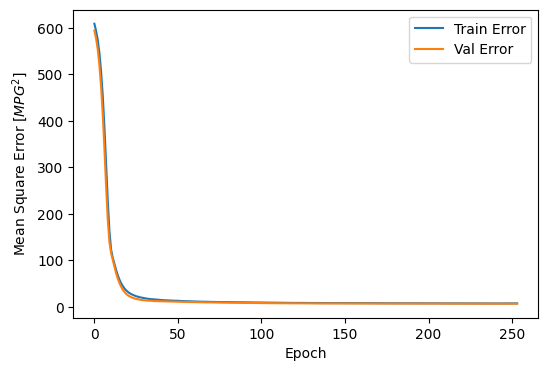

In [14]:
plt.figure(figsize=(6, 4))

plt.plot(history.history['mse'], label='Train Error')
plt.plot(history.history['val_mse'], label = 'Val Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.show()

In [15]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

테스트 세트의 평균 절대 오차:  1.85 MPG


## 예측 시각화

마지막으로 예측값과 실제값의 차이를 시각화 해 보겠습니다.

3/3 [==============================] - 0s 3ms/step


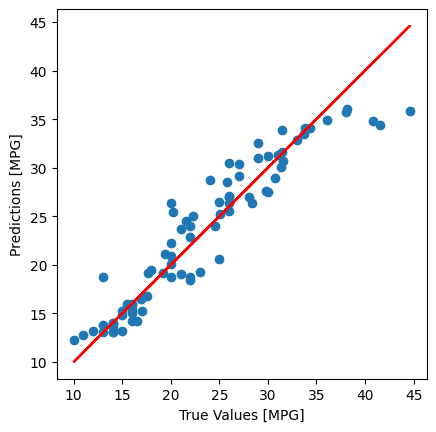

In [16]:
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c='r')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.show()